## Dataset

In [ ]:
!pip install --pre torch torchvision -f https://download.pytorch.org/whl/nightly/cu102/torch_nightly.html -U


In [ ]:
## extracting traffic data
!wget https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip .
!unzip PennFudanPed.zip

## Imports

In [1]:
## basic imports
import os
import numpy as np
## torch imports
import torch
import torch.utils.data
from torch.utils.data import Dataset

## torchvision imports
import torchvision
import torchvision.transforms as T
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
## image utilities
from PIL import Image
import matplotlib.pyplot as plt
import cv2
## code utilities
import random
import warnings
warnings.filterwarnings('ignore')

## Getting pytorch vision

In [2]:
## clone the pytorch repository to setup exact directory structures as the original trained
!git clone https://github.com/pytorch/vision.git
%cd vision
!git checkout v0.3.0

!cp references/detection/engine.py ../
!cp references/detection/transforms.py ../
!cp references/detection/utils.py ../
!cp references/detection/coco_utils.py ../
!cp references/detection/coco_eval.py ../


fatal: destination path 'vision' already exists and is not an empty directory.
/content/vision
HEAD is now at be376084d8 version check against PyTorch's CUDA version


In [4]:
## imports from the pytorch repo
import utils
import transforms as T
from engine import train_one_epoch, evaluate



In [5]:
%matplotlib inline


In [6]:
class CustomDataset(Dataset):
    def __init__(self, dir_path, transforms=None):
        ## initializing object attributes
        self.transforms = transforms
        self.dir_path = dir_path

        self.mask_list = list(sorted(os.listdir(os.path.join(dir_path, "PedMasks"))))
        self.image_list = list(sorted(os.listdir(os.path.join(dir_path, "PNGImages"))))


    def __getitem__(self, idx):
        # get images and mask
        img_path = os.path.join(self.dir_path, "PNGImages", self.image_list[idx])
        mask_path = os.path.join(self.dir_path, "PedMasks", self.mask_list[idx])
        image_obj = Image.open(img_path).convert("RGB")
        mask_obj = Image.open(mask_path)

        mask_obj = np.array(mask_obj)
        obj_ids = np.unique(mask_obj)
        # background has the first id so excluding that
        obj_ids = obj_ids[1:]
        # splitting mask into binaries
        masks_obj = mask_obj == obj_ids[:, None, None]
        # bounding box
        num_objs = len(obj_ids)
        bboxes = []
        for i in range(num_objs):
            pos = np.where(masks_obj[i])

            xmax = np.max(pos[1])
            xmin = np.min(pos[1])
            ymax = np.max(pos[0])
            ymin = np.min(pos[0])

            bboxes.append([xmin, ymin, xmax, ymax])

        image_id = torch.tensor([idx])
        masks_obj = torch.as_tensor(masks_obj, dtype=torch.uint8)
        bboxes = torch.as_tensor(bboxes, dtype=torch.float32)
        labels = torch.ones((num_objs,), dtype=torch.int64)


        area = (bboxes[:, 3] - bboxes[:, 1]) * (bboxes[:, 2] - bboxes[:, 0])

        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["image_id"] = image_id
        target["masks"] = masks_obj
        target["boxes"] = bboxes
        target["labels"] = labels


        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            image_obj, target = self.transforms(image_obj, target)

        return image_obj, target

    def __len__(self):
        return len(self.image_list)

In [7]:



def modify_model(classes_num):
    # model already trained on COCO loaded from PyTorch repository
    maskrcnn_model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    # number of input features indeitification
    in_features = maskrcnn_model.roi_heads.box_predictor.cls_score.in_features

    # head is changed
    maskrcnn_model.roi_heads.box_predictor = FastRCNNPredictor(in_features, classes_num)

    in_features_mask = maskrcnn_model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256

    maskrcnn_model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return maskrcnn_model

In [8]:


def get_transform_data(train):
    transforms = []
    # PIL image to tensor for PyTorch model
    transforms.append(T.ToTensor())
    if train:
        # basic image augmentation techniques
        ## can add few more for experimentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

# get the traffic data to transform
train_dataset = CustomDataset('/content/PennFudanPed', get_transform_data(train=True))
test_dataset = CustomDataset('/content/PennFudanPed', get_transform_data(train=False))

# train test split
torch.manual_seed(1)
indices = torch.randperm(len(train_dataset)).tolist()
train_dataset = torch.utils.data.Subset(train_dataset, indices[:-50])
test_dataset = torch.utils.data.Subset(test_dataset, indices[-50:])

# define training and validation data loaders
train_data_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=2, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn)

test_data_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)

In [9]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# since we are dealing with persons and background number of classes become 2
num_classes = 2

final_model = modify_model(num_classes)
# model to GPU or CPU if GPU not available
final_model.to(device)

## getting SGD optimizer
params = [p for p in final_model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params,
                            lr=0.005,
                            momentum=0.9,
                            weight_decay=0.0005)

# setting up step learning rate

lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=2,
                                               gamma=0.1)

In [10]:
# setting up epochs
num_epochs = 5

for epoch in range(num_epochs):
    ## using train_one_epoch from pytorch helper function itself
    # getting used to fine tuning framework
    train_one_epoch(final_model, optimizer, train_data_loader, device, epoch, print_freq=10)
    # updating the weights and learning rates
    lr_scheduler.step()
    # get the evaluation result from the resultant change in weights
    evaluate(final_model, test_data_loader, device=device)

Epoch: [0]  [ 0/60]  eta: 0:02:45  lr: 0.000090  loss: 2.7899 (2.7899)  loss_classifier: 0.7401 (0.7401)  loss_box_reg: 0.3405 (0.3405)  loss_mask: 1.6637 (1.6637)  loss_objectness: 0.0430 (0.0430)  loss_rpn_box_reg: 0.0025 (0.0025)  time: 2.7601  data: 0.3801  max mem: 2177
Epoch: [0]  [10/60]  eta: 0:00:39  lr: 0.000936  loss: 1.3951 (1.7269)  loss_classifier: 0.5153 (0.4825)  loss_box_reg: 0.2960 (0.2981)  loss_mask: 0.7158 (0.9198)  loss_objectness: 0.0169 (0.0217)  loss_rpn_box_reg: 0.0045 (0.0048)  time: 0.7802  data: 0.0474  max mem: 3225
Epoch: [0]  [20/60]  eta: 0:00:26  lr: 0.001783  loss: 1.0074 (1.2307)  loss_classifier: 0.2234 (0.3357)  loss_box_reg: 0.2923 (0.2861)  loss_mask: 0.3237 (0.5872)  loss_objectness: 0.0109 (0.0171)  loss_rpn_box_reg: 0.0042 (0.0045)  time: 0.5486  data: 0.0119  max mem: 3225
Epoch: [0]  [30/60]  eta: 0:00:18  lr: 0.002629  loss: 0.5681 (1.0159)  loss_classifier: 0.0996 (0.2553)  loss_box_reg: 0.2668 (0.2867)  loss_mask: 0.1832 (0.4538)  loss_ob

In [11]:
## saving the model full version
## can opt for state dict version of saving
torch.save(final_model, 'mask-rcnn-fine_tuned.pt')

## Inference

In [12]:
# pytorch help to set the model to eval mode
final_model.eval()
CLASSES = ['__background__', 'pedestrian']
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
final_model.to(device)

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(in

In [47]:


def get_mask_color(mask_conf):
    ## helper function to generate mask
    colour_option = [[0, 250, 0],[0, 0, 250],[250, 0, 0],[0, 250, 250],[250, 250, 0],[250, 0, 250],[75, 65, 170],[230, 75, 180],[235, 130, 40],[60, 140, 240],[40, 180, 180]]
    blue = np.zeros_like(mask_conf).astype(np.uint8)
    green = np.zeros_like(mask_conf).astype(np.uint8)
    red = np.zeros_like(mask_conf).astype(np.uint8)

    red[mask_conf == 1], green[mask_conf == 1], blue[mask_conf == 1] = colour_option[random.randrange(0,10)]
    mask_color = np.stack([red, green, blue], axis=2)
    return mask_color

def generate_prediction(image_path, conf):
    ## helper function to generate predictions
    image = Image.open(image_path)
    transform = ToTensor()
    image = transform(image)

    image = image.to(device)
    predicted = final_model([image])
    predicted_score = list(predicted[0]['scores'].detach().cpu().numpy())
    predicted_temp = [predicted_score.index(x) for x in predicted_score if x>conf][-1]
    masks = (predicted[0]['masks']>0.5).squeeze().detach().cpu().numpy()
    # print(pred[0]['labels'].numpy().max())
    predicted_class_val = [CLASSES[i] for i in list(predicted[0]['labels'].cpu().numpy())]
    predicted_box_val = [[(i[0], i[1]), (i[2], i[3])] for i in list(predicted[0]['boxes'].detach().cpu().numpy())]
    masks = masks[:predicted_temp+1]
    predicted_class_name = predicted_class_val[:predicted_temp+1]
    predicted_box_score = predicted_box_val[:predicted_temp+1]

    return masks, predicted_box_score, predicted_class_name

def segment_image(image_path, confidence=0.5, rect_thickness=2, text_size=2, text_thickness=2):

    masks_conf, box_conf, predicted_class = generate_prediction(image_path, confidence)
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    for i in range(len(masks_conf)):
      rgb_mask = get_mask_color(masks_conf[i])
      image = cv2.addWeighted(image, 1, rgb_mask, 0.5, 0)
      # cv2.rectangle(image, box_conf[i][0], box_conf[i][1],color=(0, 255, 0), thickness=rect_thickness)
      # cv2.putText(image,predicted_class[i], box_conf[i][0], cv2.FONT_HERSHEY_SIMPLEX, text_size, (0,255,0),thickness=text_thickness)
    plt.figure(figsize=(20,30))
    plt.imshow(image)
    plt.xticks([])
    plt.yticks([])
    plt.show()

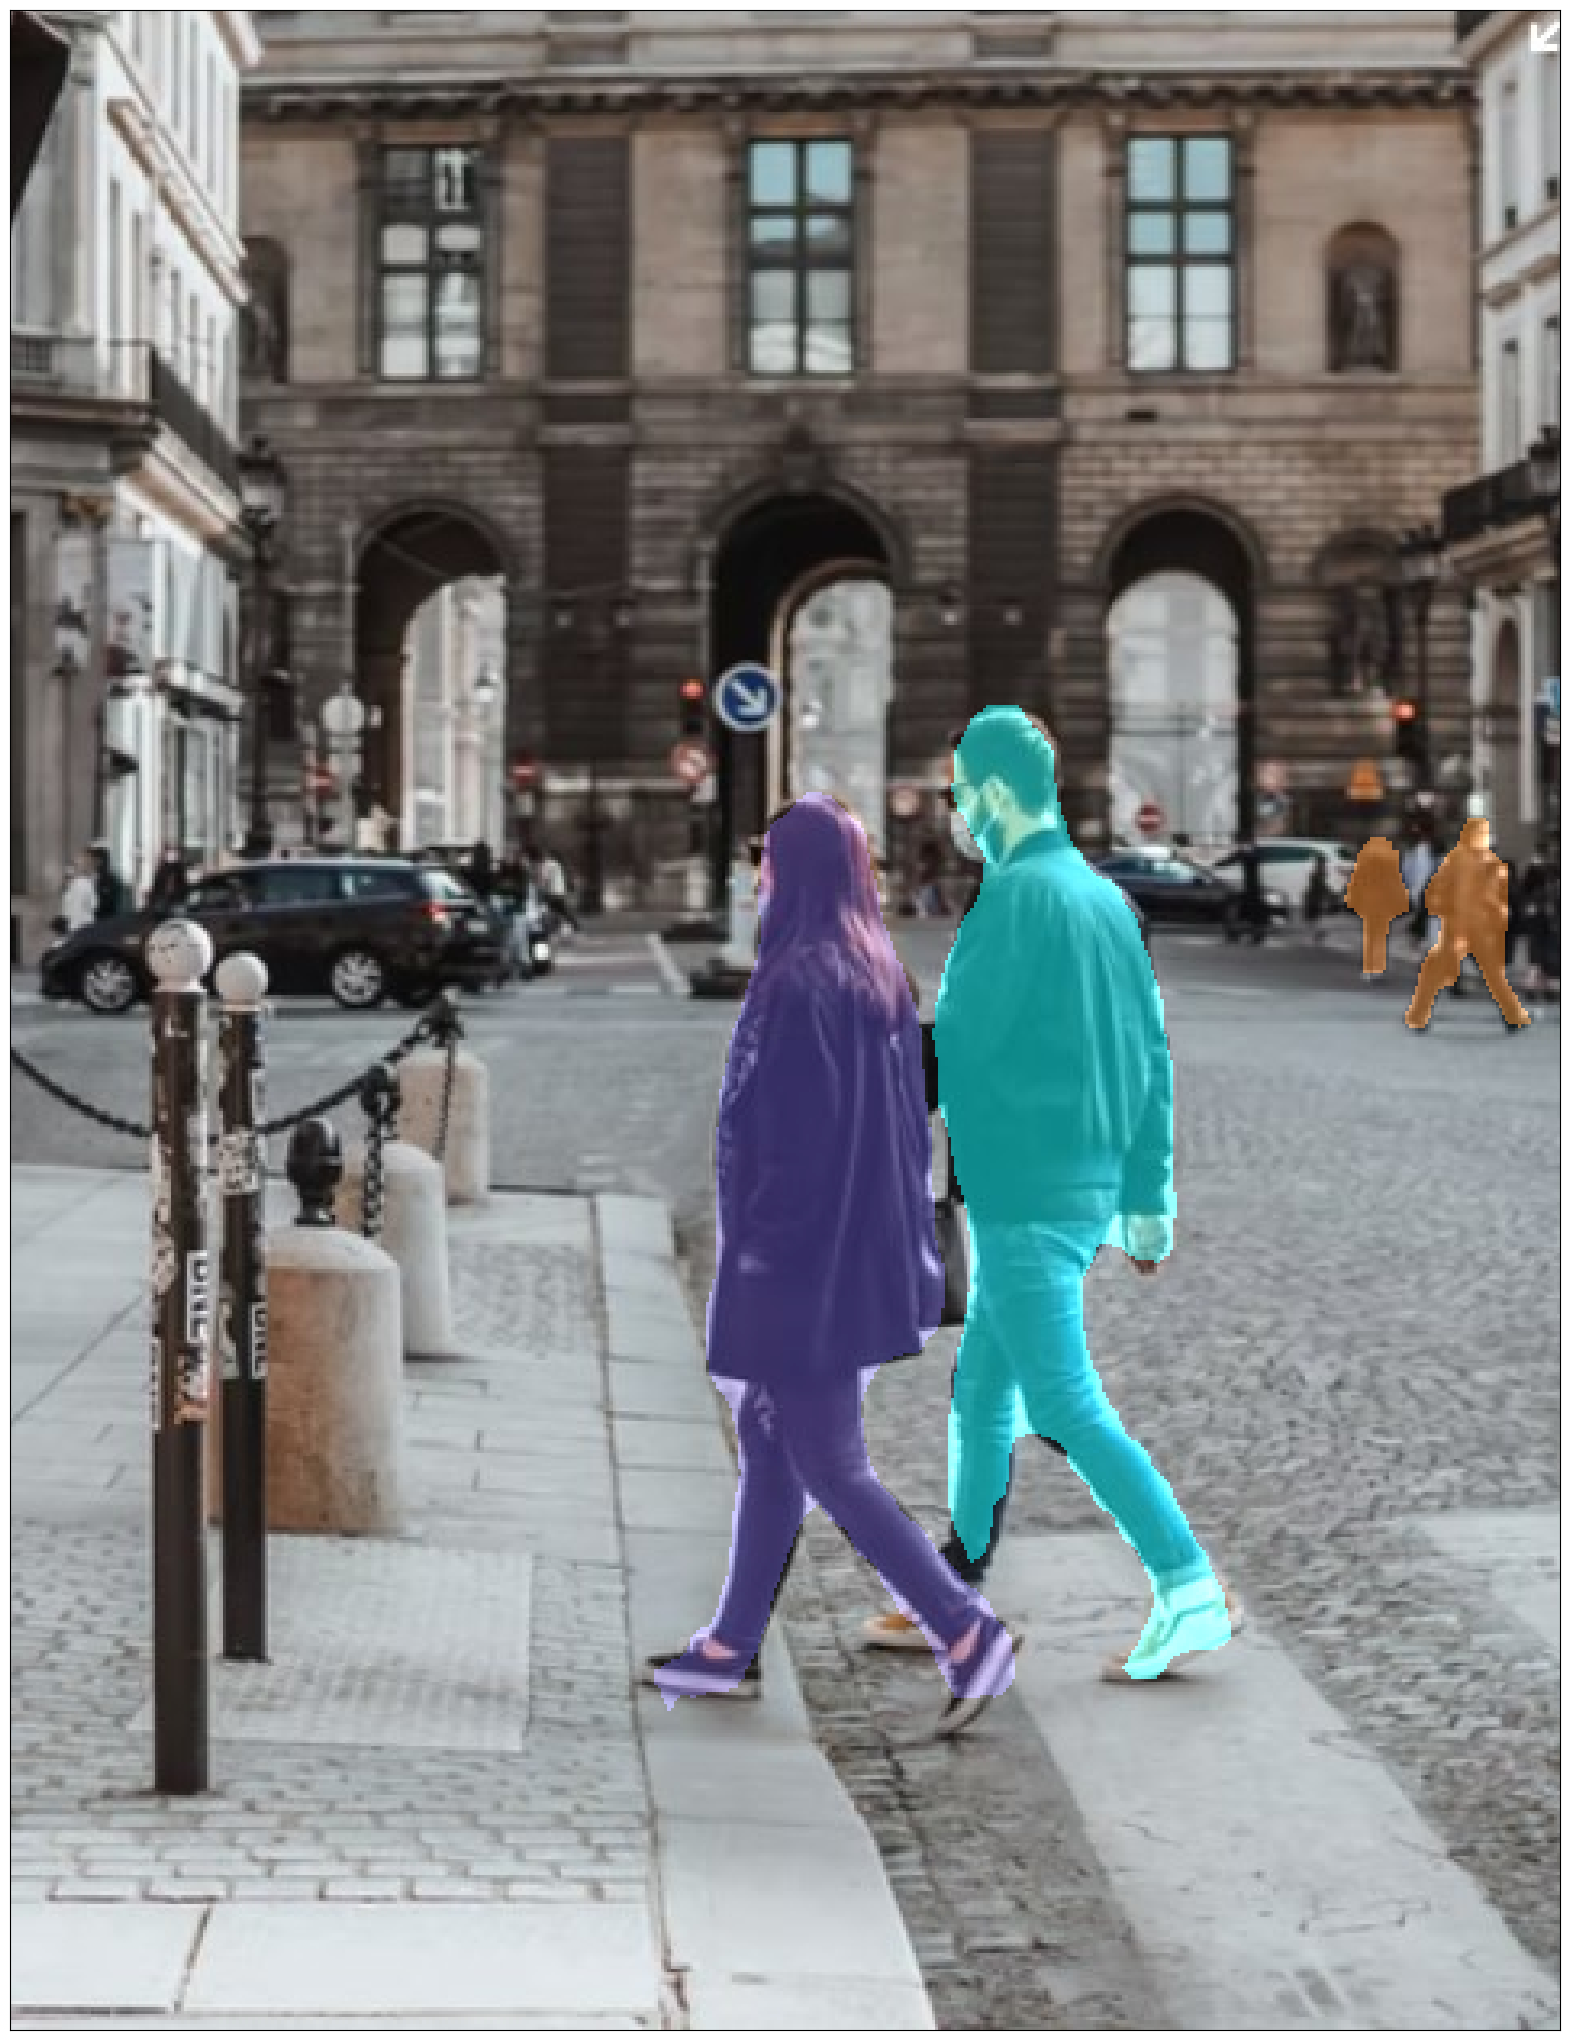

In [49]:
from torchvision.transforms import ToTensor
segment_image('/content/pedestrian_img.jpg', confidence=0.7)